In [ ]:
import spacy
import re
nlp = spacy.load("en_core_web_sm")

In [ ]:
def preprocess_text(text):
  emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # face related emojis
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F700-\U0001F77F"  # alchemical symbols
                           u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                           u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                           u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                           u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                           u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                           u"\U00002702-\U000027B0"  # Dingbats
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

  text = emoji_pattern.sub(r'', text)

  text = re.sub(r'#\w+', '', text)

  text = re.sub(r'@\w+', '', text)

  text = re.sub(r'https:\w+', '', text)

  text = text.lower().strip()

  doc = nlp(text)

  tokens = [token.text for token in doc if not token.is_stop and not token.text.isspace() and not token.is_punct]

  s=' '.join(tokens)
  doc=nlp(s)
  final_tokens=[]
  for i in doc:
    final_tokens.append(i.lemma_)
  return ' '.join(final_tokens)


In [ ]:
import pandas as pd

In [ ]:
df=pd.read_csv('/content/train-3.csv')

In [ ]:
df.shape

(7201, 4)

In [ ]:
df

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,"Was walking along crowded street, holding mums...",0,0,1
1,This incident took place in the evening.I was ...,0,1,0
2,I WAS WAITING FOR THE BUS. A MAN CAME ON A BIK...,1,0,0
3,Incident happened inside the train,0,0,0
4,I witnessed an incident when a chain was bruta...,0,0,0
...,...,...,...,...
7196,There was this person near a construction site...,0,1,0
7197,He threatened me by making inappropriate conve...,1,0,0
7198,happened during morning at university metro st...,1,0,0
7199,one day my aunt was returniec frm office .. sh...,0,0,0


In [ ]:
df['Description']=df['Description'].apply(preprocess_text)
df

,Description,Commenting,Ogling/Facial Expressions/Staring,Touching /Groping
0,walk crowded street hold mum hand elderly man ...,0,0,1
1,incident take place evening.i metro guy start ...,0,1,0
2,wait bus man come bike offer liftvto young girl,1,0,0
3,incident happen inside train,0,0,0
4,witness incident chain brutally snatch elderly...,0,0,0
...,...,...,...,...
7196,person near construction site probably laborer...,0,1,0
7197,threaten make inappropriate conversation.(thre...,1,0,0
7198,happen morning university metro station guy co...,1,0,0
7199,day aunt returniec frm office shaunt e find ga...,0,0,0


In [ ]:
def map_classes(row):
    if row['Commenting'] == 0  and row['Ogling/Facial Expressions/Staring'] == 0 and row['Touching /Groping'] == 0:
        return 0
    elif row['Commenting'] == 1:
        return 3
    elif row['Ogling/Facial Expressions/Staring'] == 1:
        return 2
    elif row['Touching /Groping'] == 1:
        return 1

df['target'] = df.apply(map_classes, axis=1)

In [ ]:
df=df.drop(['Commenting','Ogling/Facial Expressions/Staring','Touching /Groping'],axis='columns')
df

,Description,target
0,walk crowded street hold mum hand elderly man ...,1
1,incident take place evening.i metro guy start ...,2
2,wait bus man come bike offer liftvto young girl,3
3,incident happen inside train,0
4,witness incident chain brutally snatch elderly...,0
...,...,...
7196,person near construction site probably laborer...,2
7197,threaten make inappropriate conversation.(thre...,3
7198,happen morning university metro station guy co...,3
7199,day aunt returniec frm office shaunt e find ga...,0


In [ ]:
from sklearn.model_selection import train_test_split
x=df['Description']
y=df['target']
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import hamming_loss
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
from sklearn.linear_model import LogisticRegression
pipe=Pipeline([
    ('vector',TfidfVectorizer()) ,
    ('model',LogisticRegression())
])

In [ ]:
pipe.fit(x_train,y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vector', TfidfVectorizer()), ('model', LogisticRegression())])

In [ ]:
y_pred=pipe.predict(x_test)

hamming_score= 1- hamming_loss(y_test,y_pred)
print(hamming_score)

0.7113115891741846


In [ ]:
from sklearn.tree import DecisionTreeClassifier
pipe1=Pipeline([
    ('vector',TfidfVectorizer()) ,
    ('model',DecisionTreeClassifier())
])

In [ ]:
pipe1.fit(x_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer()),
                ('model', DecisionTreeClassifier())])

In [ ]:
y_pred_dt=pipe1.predict(x_test)

hamming_score_dt= 1- hamming_loss(y_test,y_pred)
print(hamming_score_dt)

0.7113115891741846


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
pipe2=Pipeline([
    ('vector',TfidfVectorizer()) ,
    ('model',KNeighborsClassifier())
])

In [ ]:
pipe2.fit(x_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer()),
                ('model', KNeighborsClassifier())])

In [ ]:

y_pred_kn=pipe.predict(x_test)

hamming_score_kn= 1- hamming_loss(y_test,y_pred)
print(hamming_score_kn)

0.7113115891741846


In [ ]:
from sklearn.svm import SVC
pipe3=Pipeline([
    ('vector',TfidfVectorizer()) ,
    ('model',SVC())
])


In [ ]:
pipe3.fit(x_train,y_train)

Pipeline(steps=[('vector', TfidfVectorizer()), ('model', SVC())])

In [ ]:
y_pred_sv=pipe3.predict(x_test)

hamming_score_sv= 1- hamming_loss(y_test,y_pred)
print(hamming_score_sv)

0.7113115891741846


Text(50.722222222222214, 0.5, 'Actual')

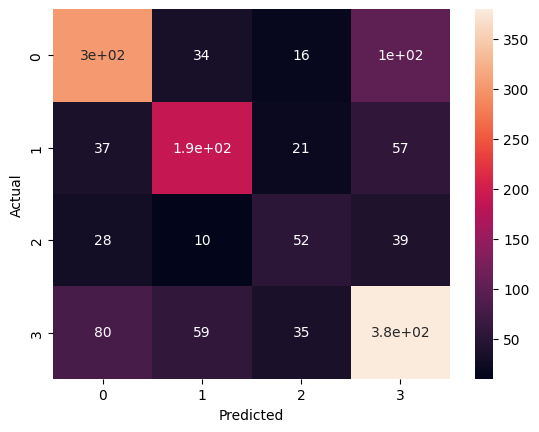

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
cm=confusion_matrix(y_test,y_pred_dt)
sns.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.68      0.80      0.74       453
           1       0.74      0.70      0.72       305
           2       0.66      0.29      0.41       129
           3       0.73      0.74      0.73       554

    accuracy                           0.71      1441
   macro avg       0.70      0.63      0.65      1441
weighted avg       0.71      0.71      0.70      1441



In [ ]:
!pip install shap

In [ ]:
import shap

In [ ]:
def predict_fn(x):
    return pipe.predict_proba(x)

# Initialize the explainer
explainer = shap.Explainer(predict_fn, x_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


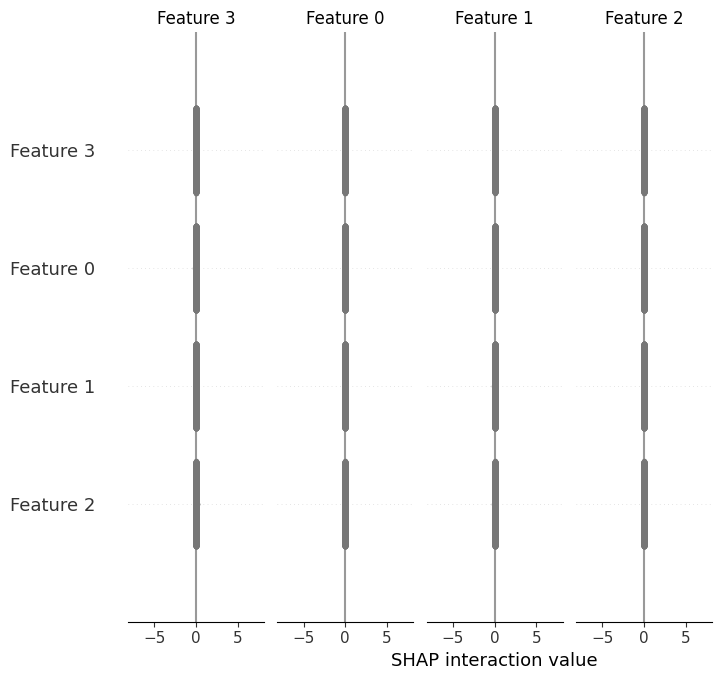

In [ ]:
vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

model = LogisticRegression()
model.fit(x_train_vectorized, y_train)


explainer = shap.Explainer(model, x_train_vectorized)
shap_values = explainer.shap_values(x_test_vectorized)
shap.summary_plot(shap_values, x_test_vectorized, plot_type='bar')
plt.show()

 98%|===================| 5670/5764 [00:27<00:00]       

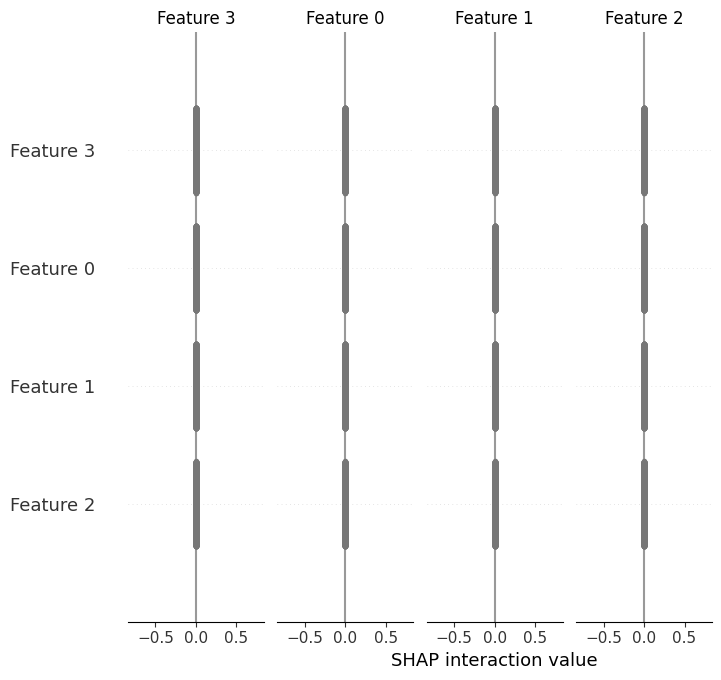

In [ ]:
x_train_dense = x_train_vectorized.toarray()
x_test_dense = x_test_vectorized.toarray().astype(float)

model = DecisionTreeClassifier()
model.fit(x_train_dense, y_train)


explainer = shap.Explainer(model, x_train_dense)


shap_values = explainer.shap_values(x_test_dense)


shap.summary_plot(shap_values, x_test_vectorized, plot_type='bar')
plt.show()


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
pipe2=Pipeline([
    ('vector',CountVectorizer()) ,
    ('model',MultinomialNB())
])

In [ ]:
pipe2.fit(x_train,y_train)

Pipeline(steps=[('vector', CountVectorizer()), ('model', MultinomialNB())])

In [ ]:
y_pred_kn=pipe.predict(x_test)

hamming_score_kn= 1- hamming_loss(y_test,y_pred)
print(hamming_score_kn)

0.7113115891741846
